In [1]:
#Importing packages
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

In [2]:
#Input the processed CRM data
santander_crm = pd.read_csv("Data/Processed/One_but_last_month_data_processsed.csv")

In [3]:
santander_crm = santander_crm[santander_crm['no_of_accounts'] > 1]

### Rule Based Segmentation

In [4]:
list(santander_crm)

['customer_code',
 'sex',
 'age',
 'new_customer_index',
 'seniority',
 'customer_relation_at_begin',
 'foreign_index',
 'province_name',
 'activity_index',
 'gross_income',
 'segmentation',
 'ind_savings_account',
 'ind_guarantees',
 'ind_current_account',
 'ind_derivada_account',
 'ind_payroll_account',
 'ind_junior_account',
 'ind_mas_particular_account',
 'ind_particular_account',
 'ind_particular_plus_account',
 'ind_short_term_deposit',
 'ind_medium_term_deposit',
 'ind_long_term_deposit',
 'ind_eaccount',
 'ind_funds',
 'ind_mortgage',
 'ind_loans',
 'ind_taxes',
 'ind_credit_cards',
 'ind_securities',
 'ind_home_accounts',
 'ind_pensions_2',
 'ind_direct_debits',
 'province_segment',
 'no_of_accounts']

In [5]:
#Rename segmentation column as customer_type
santander_crm.columns = santander_crm.columns.str.replace('segmentation', 'customer_type')

In [6]:
#Define rules to bin continuous variables : age, gross_income, seniority and no_of_accounts
santander_crm = santander_crm.assign(naccount_bin = pd.cut(santander_crm['no_of_accounts'],bins=[1,4,7,pd.np.inf],duplicates='drop',labels=[0,1,2]))

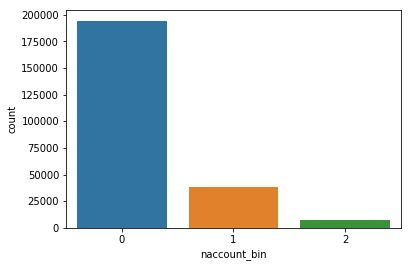

In [7]:
#Check the distribution of created bins for 
sns.countplot(santander_crm['naccount_bin'])

##### Creaating segments data based on rules

In [8]:
#Segment customers based on number of accounts
seg_nacc_low = santander_crm[santander_crm['naccount_bin'] == 0]
seg_nacc_med = santander_crm[santander_crm['naccount_bin'] == 1]
seg_nacc_high = santander_crm[santander_crm['naccount_bin'] == 2]

### Function to create the transaction data for MBA

In [9]:
list_columns = list(santander_crm)
list_accounts = list_columns[11:33]
list_accounts.append('customer_code')

In [10]:
def maketrans(transactions):
    transactions_filter = transactions[list_accounts]
    transactions_filter=transactions_filter.set_index('customer_code')
    return transactions_filter

### MBA for Number of Accounts segments

In [11]:
#Create transactions for number of accounts segments
seg_nacc_low_trans = maketrans(seg_nacc_low)
seg_nacc_med_trans = maketrans(seg_nacc_med)
seg_nacc_high_trans = maketrans(seg_nacc_high)

In [12]:
#Low Accounts Segment
frequent_itemsets = apriori(seg_nacc_low_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_nacc_low)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
1,(ind_payroll_account),(ind_pensions_2),0.153963,0.086794,0.080002,0.519617,5.98676,0.066639,1.900996,83521.5,0
0,(ind_pensions_2),(ind_payroll_account),0.086794,0.153963,0.080002,0.921740,5.98676,0.066639,10.810544,83521.5,0
2,(ind_direct_debits),(ind_payroll_account),0.358039,0.153963,0.092490,0.258324,1.67783,0.037365,1.140710,9055.36,0
3,(ind_payroll_account),(ind_direct_debits),0.153963,0.358039,0.092490,0.600729,1.67783,0.037365,1.607835,9055.36,0
5,(ind_eaccount),(ind_long_term_deposit),0.202366,0.108732,0.033613,0.166098,1.52759,0.011609,1.068792,1672.95,0
4,(ind_long_term_deposit),(ind_eaccount),0.108732,0.202366,0.033613,0.309131,1.52759,0.011609,1.154538,1672.95,0
9,(ind_direct_debits),(ind_pensions_2),0.358039,0.086794,0.042635,0.119079,1.37197,0.011559,1.036649,1424.21,0
8,(ind_pensions_2),(ind_direct_debits),0.086794,0.358039,0.042635,0.491219,1.37197,0.011559,1.261763,1424.21,0
7,(ind_direct_debits),(ind_credit_cards),0.358039,0.061586,0.027165,0.075872,1.23196,0.005115,1.015459,382.437,0
6,(ind_credit_cards),(ind_direct_debits),0.061586,0.358039,0.027165,0.441090,1.23196,0.005115,1.148596,382.437,0


## Potential Products for Low Segment : Pensions, Credit Card Account

In [13]:
#Med Accounts Segment
frequent_itemsets = apriori(seg_nacc_med_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_nacc_med)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
16,(ind_long_term_deposit),(ind_funds),0.159487,0.103193,0.039152,0.245487,2.37892,0.022694,1.188591,1586.3,0
17,(ind_funds),(ind_long_term_deposit),0.103193,0.159487,0.039152,0.379407,2.37892,0.022694,1.354370,1586.3,0
21,(ind_securities),(ind_funds),0.158964,0.103193,0.036090,0.227033,2.20009,0.019686,1.160214,1196.84,0
20,(ind_funds),(ind_securities),0.103193,0.158964,0.036090,0.349734,2.20009,0.019686,1.293372,1196.84,0
4,(ind_current_account),(ind_funds),0.322481,0.103193,0.063360,0.196478,1.90399,0.030083,1.116095,1710.15,0
5,(ind_funds),(ind_current_account),0.103193,0.322481,0.063360,0.613999,1.90399,0.030083,1.755228,1710.15,0
6,(ind_current_account),(ind_securities),0.322481,0.158964,0.089505,0.277552,1.74601,0.038243,1.164149,1913.08,0
7,(ind_securities),(ind_current_account),0.158964,0.322481,0.089505,0.563056,1.74601,0.038243,1.550584,1913.08,0
2,(ind_current_account),(ind_long_term_deposit),0.322481,0.159487,0.082491,0.255803,1.60391,0.031060,1.129422,1258.59,0
3,(ind_long_term_deposit),(ind_current_account),0.159487,0.322481,0.082491,0.517230,1.60391,0.031060,1.403399,1258.59,0


## Potential Products for Med Account Segment: Funds Account, Long term deposits

In [14]:
#High Accounts Segment
frequent_itemsets = apriori(seg_nacc_high_trans, min_support=0.02, use_colnames=True)
frequent_itemsets = frequent_itemsets[frequent_itemsets.itemsets.map(len)<3]
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)

rules['chisq'] = ''
rules['pvalue'] = ''
for i in range(0,len(rules)):
    if not ((rules['support'][i] == rules['confidence'][i]) or (rules['lift'][i] == rules['confidence'][i])):
        a=len(seg_nacc_high)
        b=(rules['lift'][i]-1)**2
        c=(rules['support'][i])*(rules['confidence'][i])
        d=(rules['confidence'][i] - rules['support'][i])
        e=(rules['lift'][i]-rules['confidence'][i])
        rules['chisq'][i] = ((a*b*c)/(d*e))
        rules['pvalue'][i] = 1-(stats.chi2.cdf(rules['chisq'][i], 1))   
        
#Removing insignificant rules based on pvalue
rules = rules[rules['pvalue'] < 0.05]
rules['lift']=round(rules['lift'],5)
rules.sort_values(by=['lift', 'antecedent support'], ascending = [False,False])

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,chisq,pvalue
2,(ind_particular_account),(ind_home_accounts),0.370988,0.043027,0.026769,0.072157,1.67701,0.010807,1.031395,86.7215,0
3,(ind_home_accounts),(ind_particular_account),0.043027,0.370988,0.026769,0.622150,1.67701,0.010807,1.664713,86.7215,0
6,(ind_long_term_deposit),(ind_funds),0.328101,0.274982,0.121794,0.371209,1.34994,0.031572,1.153034,161.82,0
7,(ind_funds),(ind_long_term_deposit),0.274982,0.328101,0.121794,0.442915,1.34994,0.031572,1.206099,161.82,0
0,(ind_particular_plus_account),(ind_particular_account),0.457323,0.370988,0.216118,0.472571,1.27382,0.046456,1.192601,265.889,0
1,(ind_particular_account),(ind_particular_plus_account),0.370988,0.457323,0.216118,0.582546,1.27382,0.046456,1.299969,265.889,0
9,(ind_securities),(ind_funds),0.401822,0.274982,0.140154,0.348797,1.26843,0.029660,1.113350,130.986,0
8,(ind_funds),(ind_securities),0.274982,0.401822,0.140154,0.509684,1.26843,0.029660,1.219985,130.986,0
4,(ind_particular_plus_account),(ind_home_accounts),0.457323,0.043027,0.023966,0.052406,1.21796,0.004289,1.009897,12.8438,0.000338606
5,(ind_home_accounts),(ind_particular_plus_account),0.043027,0.457323,0.023966,0.557003,1.21796,0.004289,1.225013,12.8438,0.000338606


## Potential Products for High Account Segment: Home Account

## Characteristics of Segments

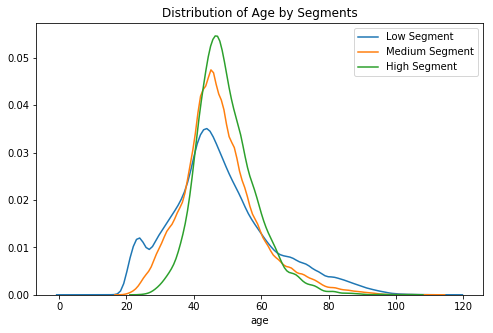

In [15]:
f, axes = plt.subplots(1, 1,figsize=(8,5))
plt.title('Distribution of Age by Segments')
sns.distplot(seg_nacc_low['age'],hist=False, label = 'Low Segment')
sns.distplot(seg_nacc_med['age'],hist=False, label = 'Medium Segment')
sns.distplot(seg_nacc_high['age'],hist=False, label = 'High Segment')

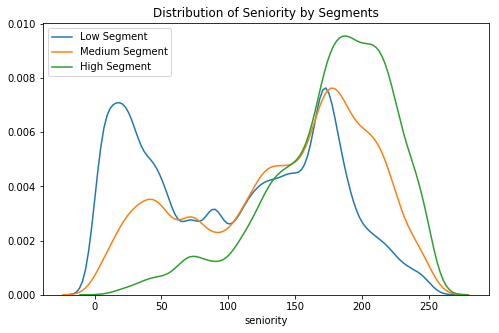

In [16]:
f, axes = plt.subplots(1, 1,figsize=(8,5))
plt.title('Distribution of Seniority by Segments')
sns.distplot(seg_nacc_low['seniority'],hist=False, label = 'Low Segment')
sns.distplot(seg_nacc_med['seniority'],hist=False, label = 'Medium Segment')
sns.distplot(seg_nacc_high['seniority'],hist=False, label = 'High Segment')

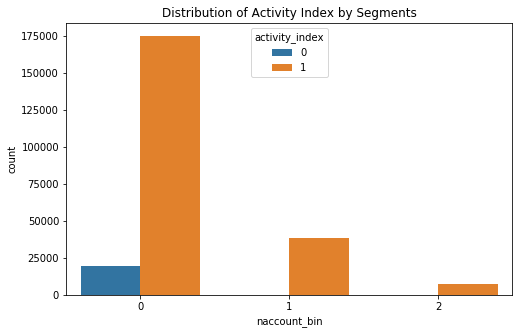

In [17]:
f, axes = plt.subplots(1, 1,figsize=(8,5))
plt.title('Distribution of Activity Index by Segments')
sns.countplot(x="naccount_bin", hue="activity_index", data=santander_crm)

## Popular Products for each segment

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

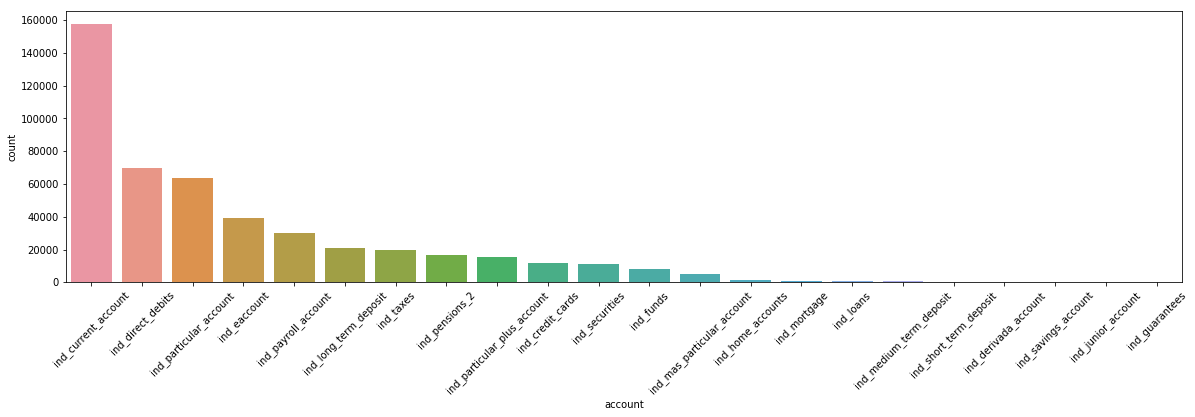

In [18]:
#Countplot to view the most popular produts in segment 1
seg_nacc_low_trans_stack=seg_nacc_low_trans.stack().to_frame().reset_index()
seg_nacc_low_trans_stack.columns=['customer_code','account','indicator']
seg_nacc_low_trans_stack=seg_nacc_low_trans_stack[seg_nacc_low_trans_stack.indicator == 1]
plt.figure(figsize=(20,5))
sns.countplot(seg_nacc_low_trans_stack['account'],order=seg_nacc_low_trans_stack['account'].value_counts().index)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21]), <a list of 22 Text xticklabel objects>)

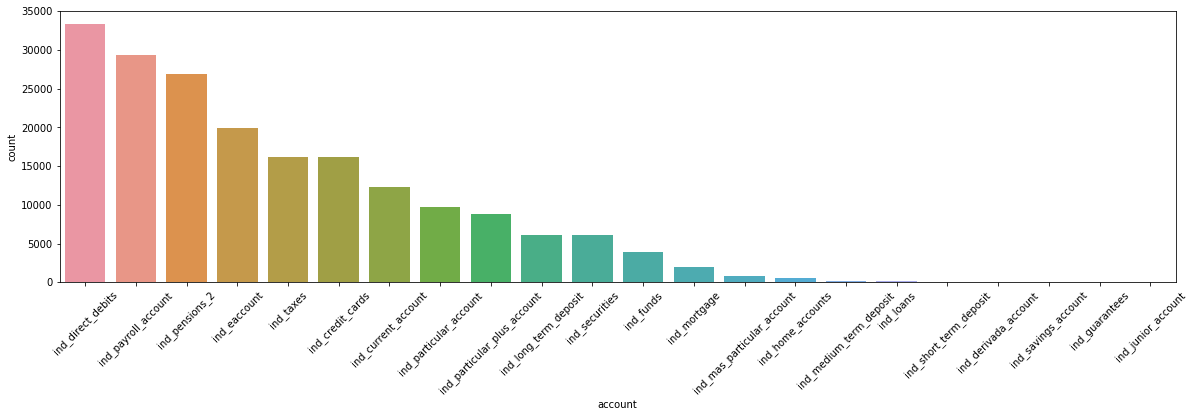

In [19]:
#Countplot to view the most popular produts in segment 2
seg_nacc_med_trans_stack=seg_nacc_med_trans.stack().to_frame().reset_index()
seg_nacc_med_trans_stack.columns=['customer_code','account','indicator']
seg_nacc_med_trans_stack=seg_nacc_med_trans_stack[seg_nacc_med_trans_stack.indicator == 1]
plt.figure(figsize=(20,5))
sns.countplot(seg_nacc_med_trans_stack['account'],order=seg_nacc_med_trans_stack['account'].value_counts().index)
plt.xticks(rotation=45)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20]), <a list of 21 Text xticklabel objects>)

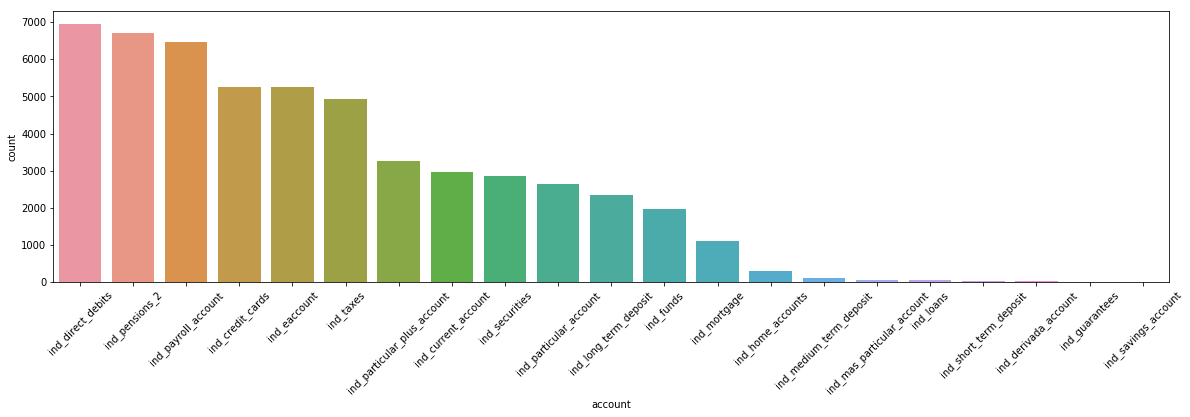

In [20]:
#Countplot to view the most popular produts in segment 3
seg_nacc_high_trans_stack=seg_nacc_high_trans.stack().to_frame().reset_index()
seg_nacc_high_trans_stack.columns=['customer_code','account','indicator']
seg_nacc_high_trans_stack=seg_nacc_high_trans_stack[seg_nacc_high_trans_stack.indicator == 1]
plt.figure(figsize=(20,5))
sns.countplot(seg_nacc_high_trans_stack['account'],order=seg_nacc_high_trans_stack['account'].value_counts().index)
plt.xticks(rotation=45)

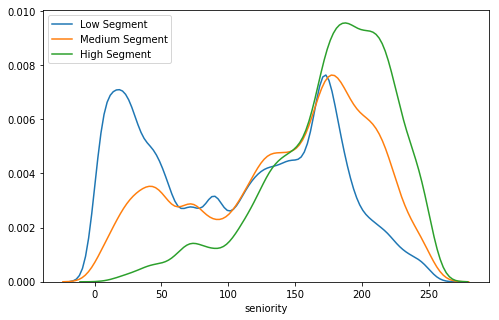

In [21]:
f, axes = plt.subplots(1, 1,figsize=(8,5))
sns.distplot(seg_nacc_low['seniority'],hist=False, label = 'Low Segment')
sns.distplot(seg_nacc_med['seniority'],hist=False, label = 'Medium Segment')
sns.distplot(seg_nacc_high['seniority'],hist=False, label = 'High Segment')

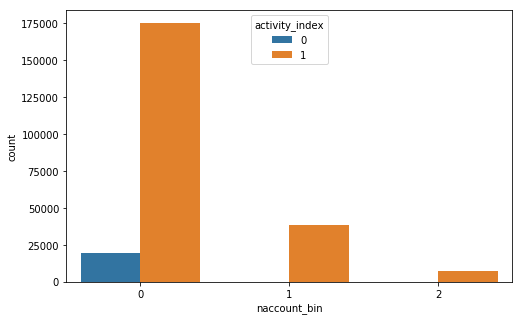

In [22]:
f, axes = plt.subplots(1, 1,figsize=(8,5))
sns.countplot(x="naccount_bin", hue="activity_index", data=santander_crm)